# ex3 - Pruning in Keras CNN model

範例說明:

1. 訓練一個`tf.keras` model for Cifar10 dataset.
2. 使用Pruning API進行模型最佳化，並觀察最佳化後之結果.(準確率損失,容量精減比率)
3. 將model透過pruning 及 quantization 壓縮成原本的1/10倍小的TFLite檔案

[參考官網 - Pruning in Keras example](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras)

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#安裝最佳化套件
! pip install -q tensorflow-model-optimization

In [ ]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

## Train a model without pruning

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)

In [ ]:
# cifar10 中有將 data 先分為 train 和 test
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# x_train.shape: 四個維度：第 1 維度為筆數、第 2, 3 維度為影像大小 32*32、第 4 維度是 RGB 三原色，所以是 3
# x_train 中有 50000 筆訓練資料，以及 x_test 中有 10000 筆的測試資料

x_train shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
50000 train samples
10000 test samples


In [ ]:
# 記得轉成 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將 features (照片影像特徵值) 標準化，可以提高模型預測的準確度，並且更快收斂
x_train /= 255  # rescaling
x_test /= 255   # rescaling

In [ ]:
# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = 10
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [ ]:
from keras.models import load_model
VGG_model = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_org.h5')
NASNetLarge_model = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_org.h5')
MobileNetV2_model = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_org.h5')

In [ ]:
VGG_model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #SparseCategoricalCrossentrop
              metrics=['accuracy'])

NASNetLarge_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #SparseCategoricalCrossentrop
              metrics=['accuracy'])

MobileNetV2_model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #SparseCategoricalCrossentrop
              metrics=['accuracy'])


評估Baseline model的 baseline test accuracy 分數, 並將模型及權重存檔 (稍後評比時會用到)

## Fine-tune pre-trained model with pruning


將baseline model進行pruning(權重剪枝)，透過幾個Fine-tune epochs，取得模型權重剪枝的結果

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% 訓練集資料做為 validation set. 

num_images = x_train.shape[0] * (1 - validation_split)

#np.ceil(a) np.floor(a) : 計算各元素的ceiling 值， floor值（ceiling向上取整，floor向下取整）
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30, #起始稀疏度
                                                               final_sparsity=0.60, #最終稀疏度
                                                               begin_step=0,
                                                               end_step=end_step)
}

VGG_model_for_pruning = prune_low_magnitude(VGG_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
VGG_model_for_pruning.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NASNetLarge_model_for_pruning = prune_low_magnitude(NASNetLarge_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
NASNetLarge_model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MobileNetV2_model_for_pruning = prune_low_magnitude(VGG_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
MobileNetV2_model_for_pruning.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

VGG_model_for_pruning.summary()
NASNetLarge_model_for_pruning.summary()
MobileNetV2_model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
prune_low_magnitude_block1_c (None, 32, 32, 64)        3522      
_________________________________________________________________
prune_low_magnitude_block1_c (None, 32, 32, 64)        73794     
_________________________________________________________________
prune_low_magnitude_block1_p (None, 16, 16, 64)        1         
_________________________________________________________________
prune_low_magnitude_block2_c (None, 16, 16, 128)       147586    
_________________________________________________________________
prune_low_magnitude_block2_c (None, 16, 16, 128)       295042    
______________________________________________

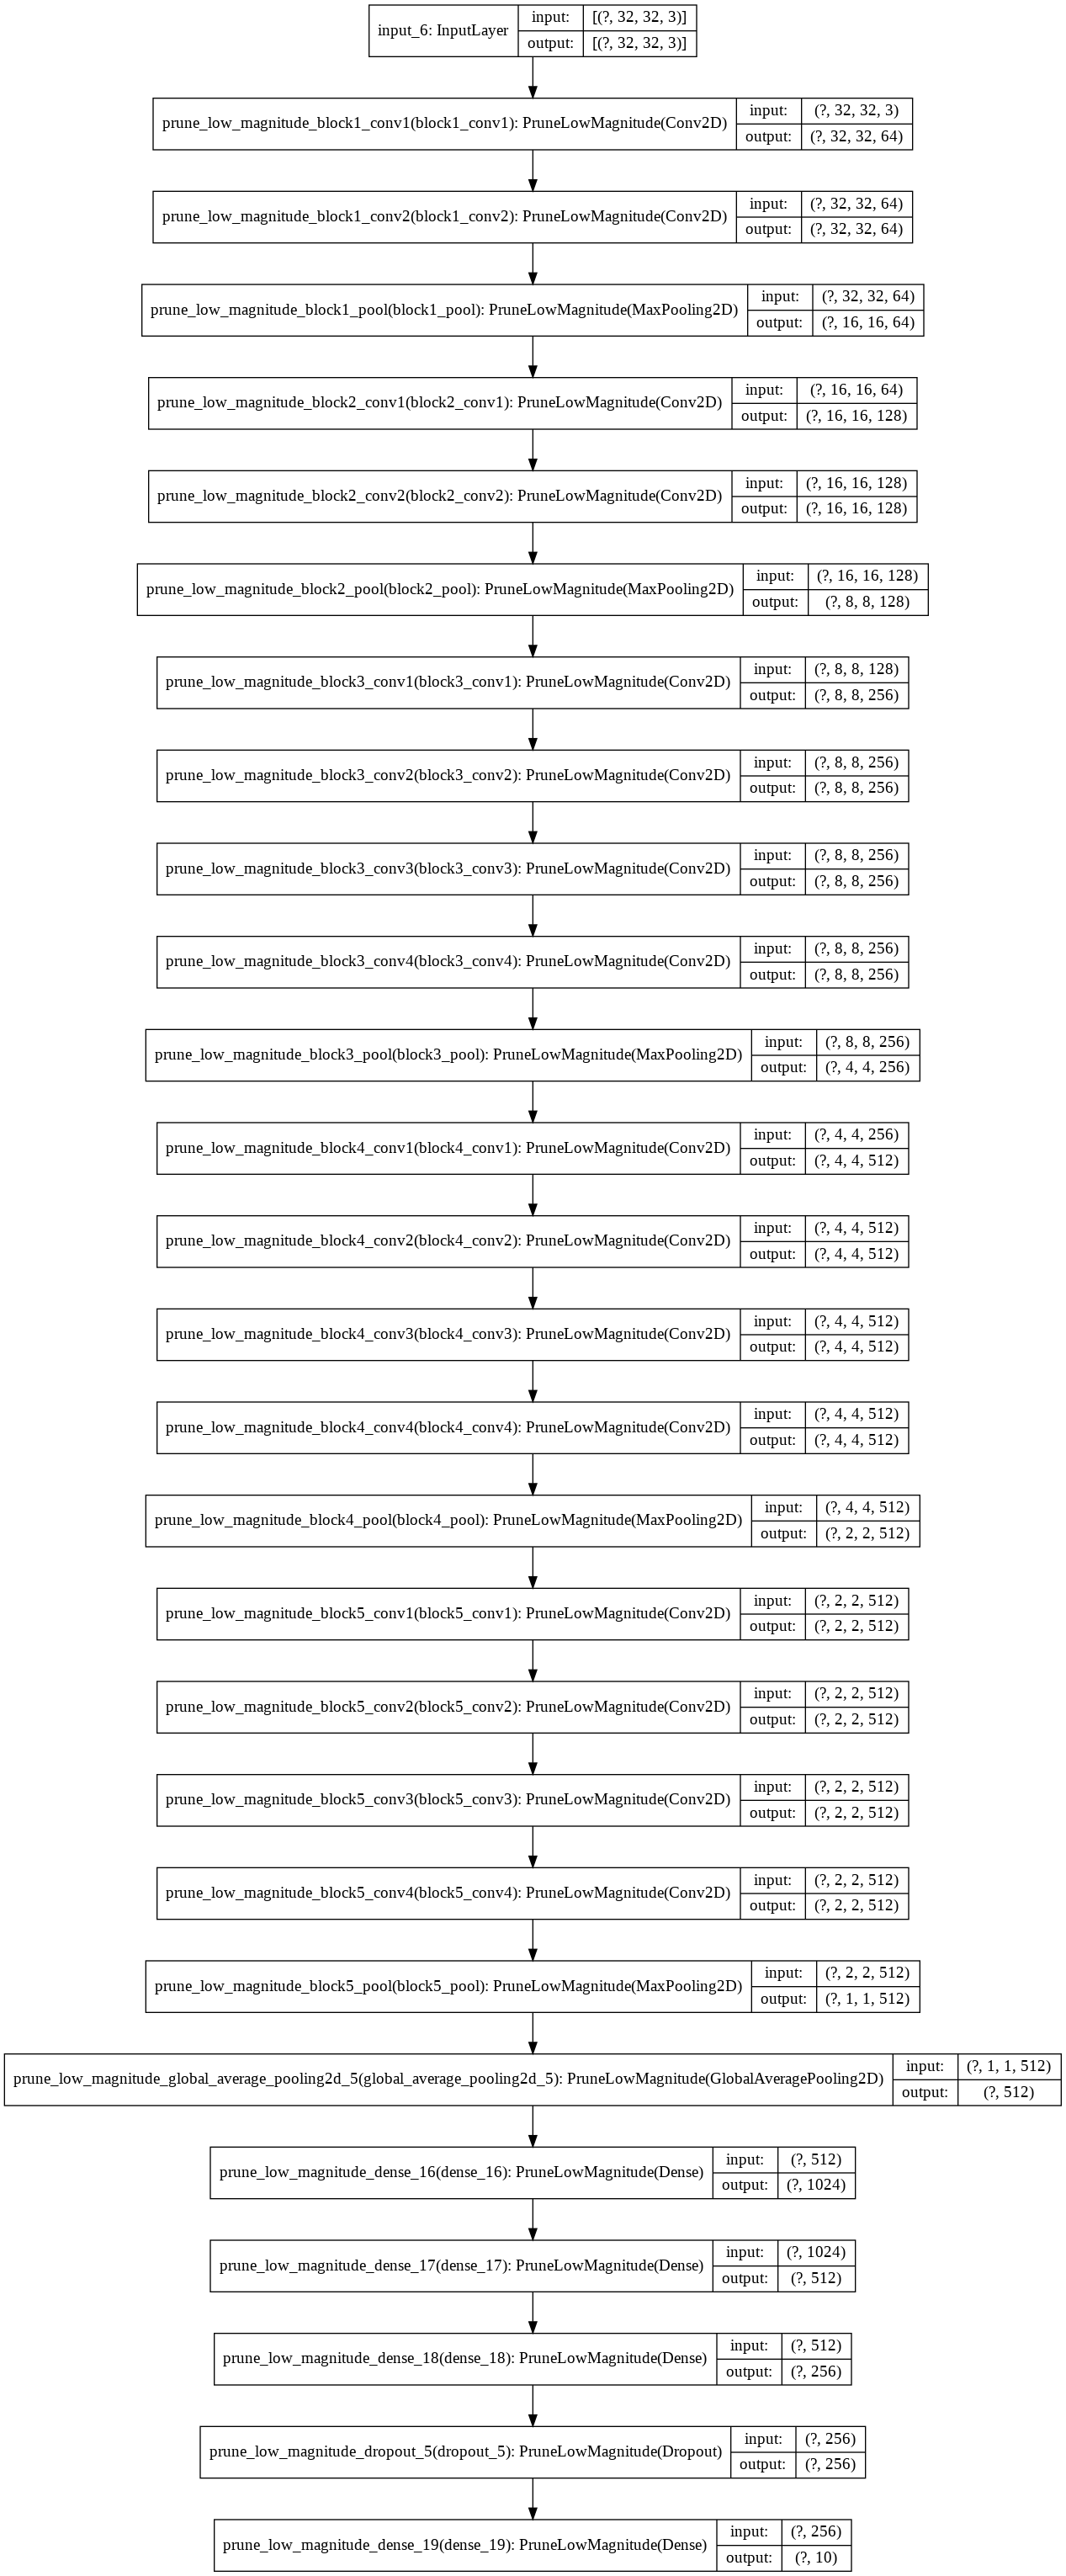

In [ ]:
tf.keras.utils.plot_model(
 VGG_model_for_pruning,
 to_file='/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_for_pruning.png',
  show_shapes=True,
 show_layer_names=True,
 rankdir='TB',
 expand_nested=True,
 dpi=96,
)

In [ ]:
tf.keras.utils.plot_model(
 NASNetLarge_model_for_pruning,
 to_file='/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarg2/NASNetLarge2_model_for_pruning.png',
 show_shapes=True,
 show_layer_names=True,
 rankdir='TB',
 expand_nested=True,
 dpi=96,
)

Output hidden; open in https://colab.research.google.com to view.

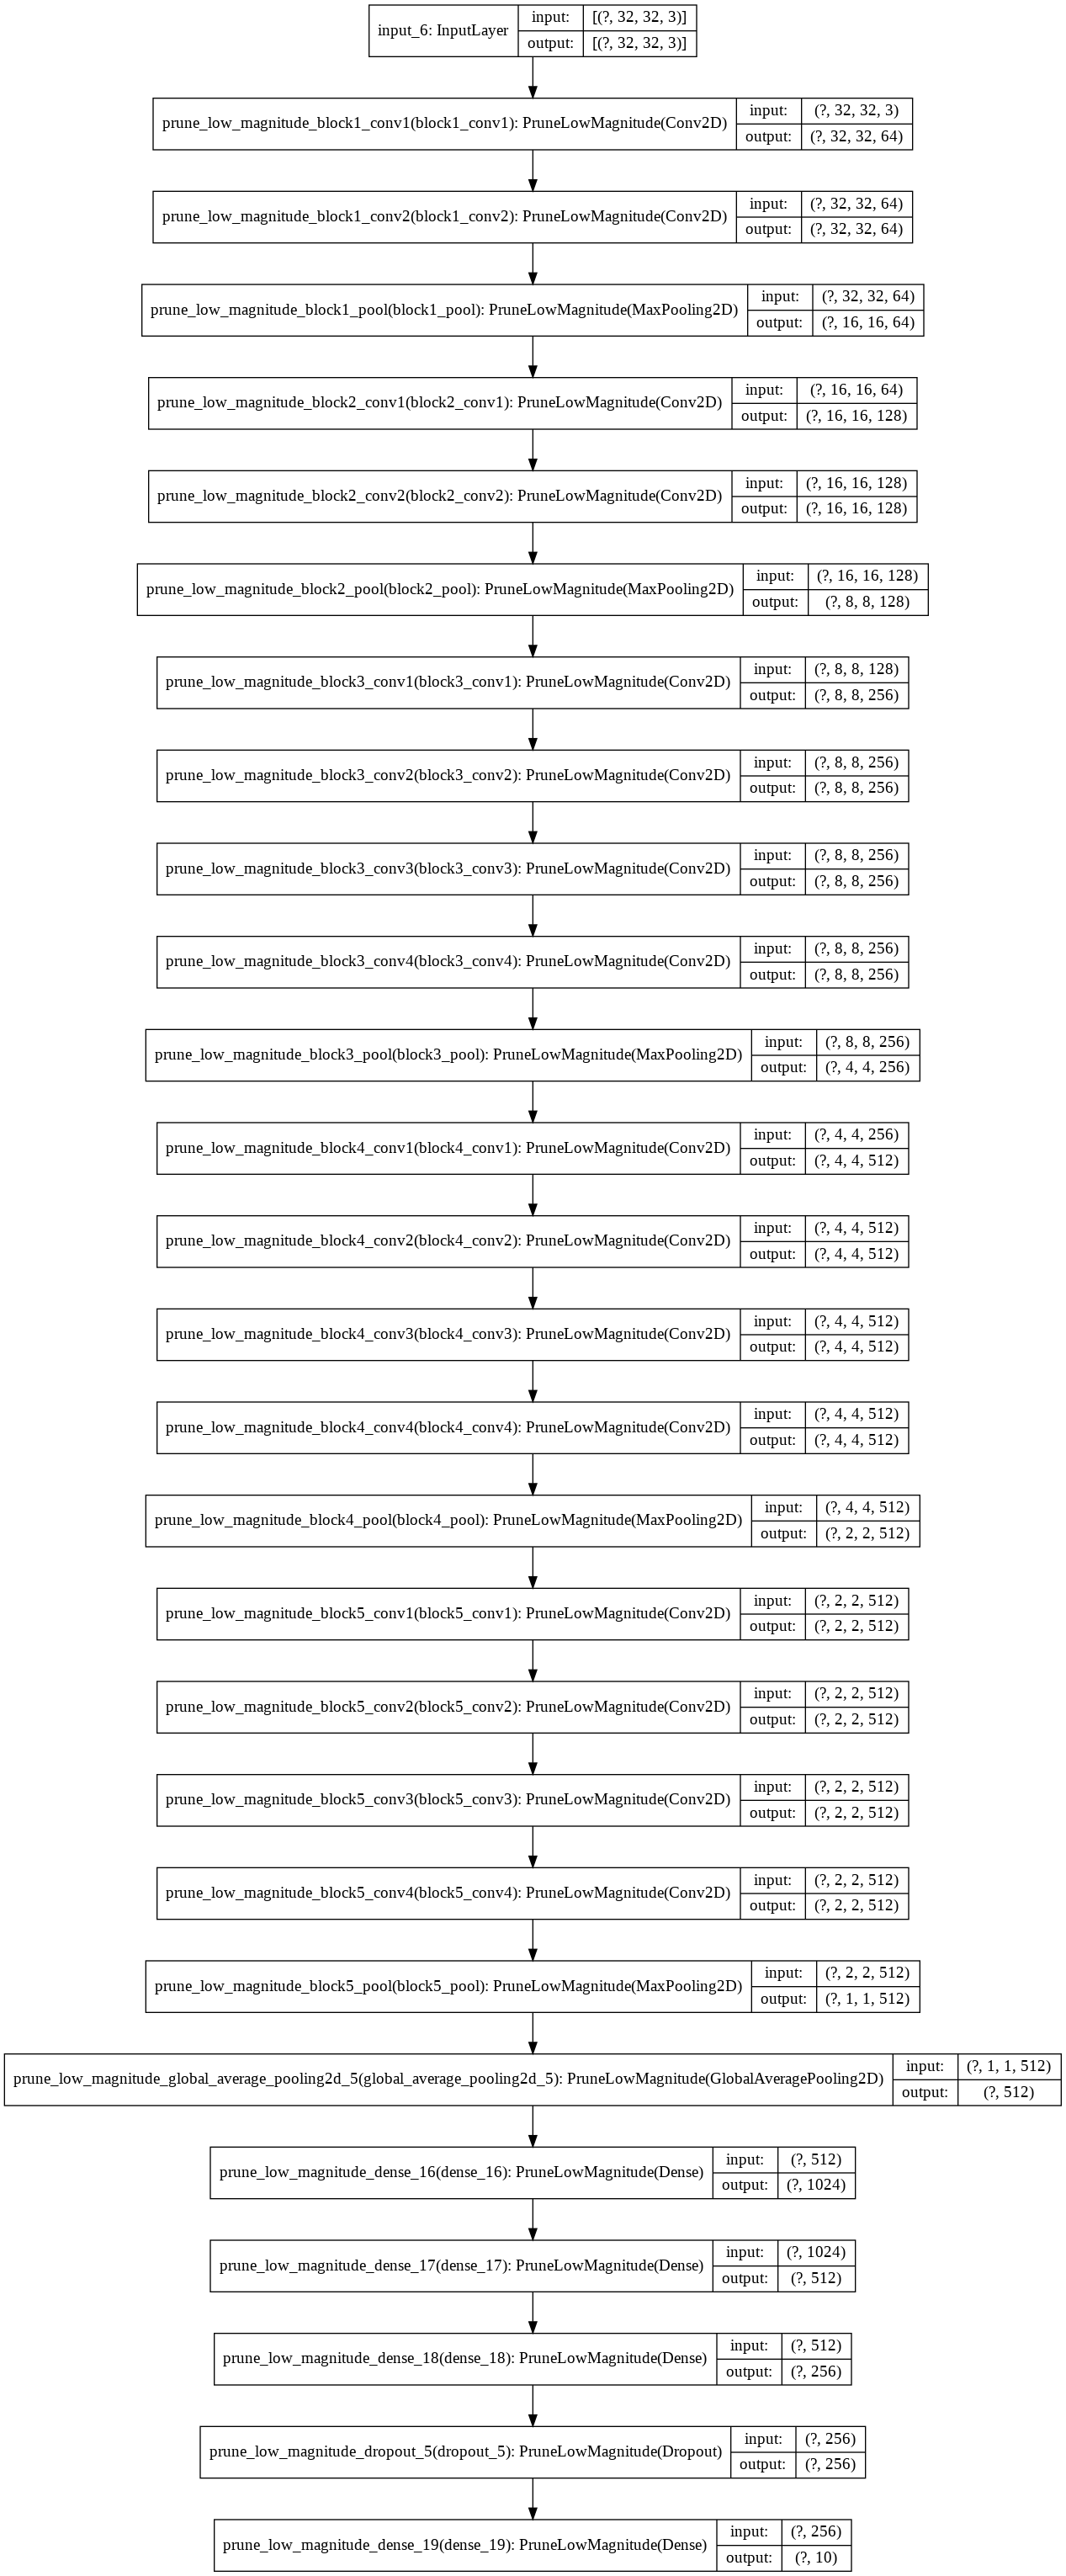

In [ ]:
tf.keras.utils.plot_model(
 MobileNetV2_model_for_pruning,
 to_file='/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_for_pruning.png',
 show_shapes=True,
 show_layer_names=True,
 rankdir='TB',
 expand_nested=True,
 dpi=96,
)

### Train and evaluate the model against baseline

在Fine-tune epochs過程中加入兩個callbacks功能，來記錄fine-tuning過程的資訊，以利偵錯。
1. 更新Pruning step資訊: `tfmot.sparsity.keras.UpdatePruningStep`
2. 記錄Pruning過程的摘要logs: `tfmot.sparsity.keras.PruningSummaries`

In [ ]:
VGG_logdir = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_logs-pruning'
NASNetLarge_logdir = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_logs-quant-aware'
MobileNetV2_logdir = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_logs-quant-aware'

print('Summaries VGG_logdir:', VGG_logdir)
print('Summaries NASNetLarge_logdir:', NASNetLarge_logdir)
print('Summaries MobileNetV2_logdir:', MobileNetV2_logdir)

#建立callbacks
VGG_callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=VGG_logdir),
]

NASNetLarge_callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=NASNetLarge_logdir),
]

MobileNetV2_callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=MobileNetV2_logdir),
]

train_images_subset = x_train[0:10000] # out of 50000
train_labels_subset = y_train[0:10000]

VGG_model_for_pruning.fit(train_images_subset, train_labels_subset,
                  batch_size=200, epochs=10, validation_split=0.1, callbacks=VGG_callbacks)

NASNetLarge_model_for_pruning.fit(train_images_subset, train_labels_subset,
                  batch_size=200, epochs=10, validation_split=0.1, callbacks=NASNetLarge_callbacks)

MobileNetV2_model_for_pruning.fit(train_images_subset, train_labels_subset,
                  batch_size=200, epochs=10, validation_split=0.1, callbacks=MobileNetV2_callbacks)

Summaries VGG_logdir: /content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_logs-pruning
Summaries NASNetLarge_logdir: /content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge/NASNetLarge_logs-quant-aware
Summaries MobileNetV2_logdir: /content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_logs-quant-aware
Epoch 1/10
 1/45 [..............................] - ETA: 0s - loss: 2.1189 - accuracy: 0.4200WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - 3s 72ms/step - loss: 2.0623 - accuracy: 0.4979 - val_loss: 2.0174 - val_accuracy: 0.5710
Epoch 2/10
45/45 [==============================] - 2s 42ms/step - loss: 2.0031 - accuracy: 0.5596 - val_loss: 1.9664 - val_accuracy: 0.5920
Epoch 3/10
45/45 [==============

評估模型在pruning前與後的準確率差異

In [ ]:
_, VGG_baseline_model_accuracy = VGG_model.evaluate( x_test, y_test, verbose=0)
_, NASNetLarge_baseline_model_accuracy = NASNetLarge_model.evaluate( x_test, y_test, verbose=0)
_, MobileNetV2_baseline_model_accuracy = MobileNetV2_model.evaluate( x_test, y_test, verbose=0)

_, VGG_model_for_pruning_accuracy = VGG_model_for_pruning.evaluate( x_test, y_test, verbose=0)
_, NASNetLarge_model_for_pruning_accuracy = NASNetLarge_model_for_pruning.evaluate( x_test, y_test, verbose=0)
_, MobileNetV2_model_for_pruning_accuracy = MobileNetV2_model_for_pruning.evaluate( x_test, y_test, verbose=0)

print('VGG_Baseline test accuracy:', VGG_baseline_model_accuracy)
print('VGG_prune test accuracy:', VGG_model_for_pruning_accuracy)

print('NASNetLarge_Baseline test accuracy:', NASNetLarge_baseline_model_accuracy)
print('NASNetLarge_prune test accuracy:', NASNetLarge_model_for_pruning_accuracy)

print('MobileNetV2_Baseline test accuracy:', MobileNetV2_baseline_model_accuracy)
print('MobileNetV2_prune test accuracy:', MobileNetV2_model_for_pruning_accuracy)

VGG_Baseline test accuracy: 0.33160001039505005
VGG_Quant-aware test accuracy: 0.33160001039505005
NASNetLarge_Baseline test accuracy: 0.125900000333786
NASNetLarge_Quant-aware test accuracy: 0.125900000333786
MobileNetV2_Baseline test accuracy: 0.5958999991416931
MobileNetV2_Quant-aware test accuracy: 0.33160001039505005


## 使用tensorboard 可以查看pruning logs的過程記錄
請練習使用hub server的Tensorboard功能

In [ ]:
#docs_infra: no_execute
#%tensorboard --logdir={logdir}

## 建立 pruning 後的模型檔案 (預計比原本小3倍)

利用 `tfmot.sparsity.keras.strip_pruning` 建立pruned壓縮模型，並存成.h5模型檔案

In [ ]:
VGG_model_for_export = tfmot.sparsity.keras.strip_pruning(VGG_model_for_pruning)
NASNetLarge_model_for_export = tfmot.sparsity.keras.strip_pruning(NASNetLarge_model_for_pruning)
MobileNetV2_model_for_export = tfmot.sparsity.keras.strip_pruning(MobileNetV2_model_for_pruning)

VGG_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.h5'
MobileNetV2_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.h5'
NASNetLarge_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_pruned.h5'

tf.keras.models.save_model(VGG_model_for_export, VGG_pruned_keras_file, include_optimizer=False)
tf.keras.models.save_model(MobileNetV2_model_for_export, MobileNetV2_pruned_keras_file, include_optimizer=False)
tf.keras.models.save_model(NASNetLarge_model_for_export, NASNetLarge_pruned_keras_file, include_optimizer=False)

print('Saved VGG_pruned Keras model to:', VGG_pruned_keras_file)
print('Saved MobileNetV2_pruned Keras model to:', MobileNetV2_pruned_keras_file)
print('Saved NASNetLarge_pruned Keras model to:', NASNetLarge_pruned_keras_file)

Saved VGG_pruned Keras model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.h5
Saved MobileNetV2_pruned Keras model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.h5
Saved NASNetLarge_pruned Keras model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge/NASNetLarge_model_pruned.h5


In [ ]:
# Because of OOM rerun the bellow section seperately thus reload the models 
VGG_model_for_export = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.h5')
NASNetLarge_model_for_export = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_pruned.h5')
MobileNetV2_model_for_export = load_model('/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.h5')

將pruned model轉成TFLite檔案，並存檔

In [ ]:
VGG_converter = tf.lite.TFLiteConverter.from_keras_model(VGG_model_for_export)
NASNetLarge_converter = tf.lite.TFLiteConverter.from_keras_model(NASNetLarge_model_for_export)
MobileNetV2_converter = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2_model_for_export)

VGG_tflite_pruned_model = VGG_converter.convert()
NASNetLarge_tflite_pruned_model = NASNetLarge_converter.convert()
MobileNetV2_tflite_pruned_model = MobileNetV2_converter.convert()

VGG_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.tflite'
NASNetLarge_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_pruned.tflite'
MobileNetV2_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.tflite'

with open(VGG_pruned_tflite_file, 'wb') as f:
    f.write(VGG_tflite_pruned_model)

print('Saved VGG TFLite model to:', VGG_pruned_tflite_file)

with open(NASNetLarge_pruned_tflite_file, 'wb') as f:
    f.write(NASNetLarge_tflite_pruned_model)

print('Saved NASNetLarge TFLite model to:', NASNetLarge_pruned_tflite_file)

with open(MobileNetV2_pruned_tflite_file, 'wb') as f:
    f.write(MobileNetV2_tflite_pruned_model)

print('Saved MobileNetV2 TFLite model to:', MobileNetV2_pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp12tmzhin/assets


INFO:tensorflow:Assets written to: /tmp/tmp12tmzhin/assets


INFO:tensorflow:Assets written to: /tmp/tmptr2yb7zn/assets


INFO:tensorflow:Assets written to: /tmp/tmptr2yb7zn/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3vwlx78/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3vwlx78/assets


Saved VGG TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.tflite
Saved NASNetLarge TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge/NASNetLarge_model_pruned.tflite
Saved MobileNetV2 TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.tflite


定義一個工具函數"get_gzipped_model_size"將模型檔案壓成.zip的檔案格式

In [ ]:
def get_gzipped_model_size(file_with_path):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    zipped_file = file_with_path+'.zip'
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file_with_path)

    return os.path.getsize(zipped_file)

比較一下這些模型的zip檔案，在pruning前/後之檔案大小

In [ ]:
VGG_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_org.h5'
NASNetLarge_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_org.h5'
MobileNetV2_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_org.h5'

VGG_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_pruned.h5'
MobileNetV2_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_pruned.h5'
NASNetLarge_pruned_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_pruned.h5'

VGG_quant_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_quant.tflite'
MobileNetV2_quant_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_quant.tflite'
NASNetLarge_quant_keras_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_quant.tflite'

In [ ]:
print("Size of gzipped VGG baseline Keras model: %.2f bytes" % (get_gzipped_model_size(VGG_keras_file)))
print("Size of gzipped VGG pruned Keras model: %.2f bytes" % (get_gzipped_model_size(VGG_pruned_keras_file)))
print("Size of gzipped VGG pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(VGG_pruned_tflite_file)))
print("Size of gzipped VGG quant TFlite model: %.2f bytes" % (get_gzipped_model_size(VGG_quant_keras_file)))

print("Size of gzipped NASNetLarge baseline Keras model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_keras_file)))
print("Size of gzipped NASNetLarge pruned Keras model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_pruned_keras_file)))
print("Size of gzipped NASNetLarge pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_pruned_tflite_file)))
print("Size of gzipped NASNetLarge quant TFlite model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_quant_keras_file)))

print("Size of gzipped MobileNetV2 baseline Keras model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_keras_file)))
print("Size of gzipped MobileNetV2 pruned Keras model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_pruned_keras_file)))
print("Size of gzipped MobileNetV2 pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_pruned_tflite_file)))
print("Size of gzipped MobileNetV2 quant TFlite model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_quant_keras_file)))

Size of gzipped baseline Keras model: 78868492.00 bytes
Size of gzipped pruned Keras model: 26784619.00 bytes
Size of gzipped pruned TFlite model: 26737006.00 bytes
Size of gzipped baseline Keras model: 333136413.00 bytes
Size of gzipped pruned Keras model: 118756914.00 bytes
Size of gzipped pruned TFlite model: 117850164.00 bytes
Size of gzipped baseline Keras model: 28362511.00 bytes
Size of gzipped pruned Keras model: 26784661.00 bytes
Size of gzipped pruned TFlite model: 26737038.00 bytes


## 建立一個結合 pruning and quantization 兩種模型最佳化技術的壓縮模型檔案
預計會有小於原本模型大小10倍的效果

In [ ]:
VGG_converter = tf.lite.TFLiteConverter.from_keras_model(VGG_model_for_export)
NASNetLarge_converter = tf.lite.TFLiteConverter.from_keras_model(NASNetLarge_model_for_export)
MobileNetV2_converter = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2_model_for_export)

VGG_converter.optimizations = [tf.lite.Optimize.DEFAULT]
NASNetLarge_converter.optimizations = [tf.lite.Optimize.DEFAULT]
MobileNetV2_converter.optimizations = [tf.lite.Optimize.DEFAULT]

VGG_quantized_and_pruned_tflite_model = VGG_converter.convert()
NASNetLarge_quantized_and_pruned_tflite_model = NASNetLarge_converter.convert()
MobileNetV2_quantized_and_pruned_tflite_model = MobileNetV2_converter.convert()

VGG_quantized_and_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_quantized_and_pruned.tflite'
NASNetLarge_quantized_and_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge2/NASNetLarge2_model_quantized_and_pruned.tflite'
MobileNetV2_quantized_and_pruned_tflite_file = '/content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_quantized_and_pruned.tflite'

with open(VGG_quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(VGG_quantized_and_pruned_tflite_model)
with open(NASNetLarge_quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(NASNetLarge_quantized_and_pruned_tflite_model)
with open(MobileNetV2_quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(MobileNetV2_quantized_and_pruned_tflite_model)

print('Saved VGG quantized and pruned TFLite model to:', VGG_quantized_and_pruned_tflite_file)
print("Size of VGG gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(VGG_keras_file)))
print("Size of VGG gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(VGG_quantized_and_pruned_tflite_file)))

print('Saved NASNetLarge quantized and pruned TFLite model to:', NASNetLarge_quantized_and_pruned_tflite_file)
print("Size of NASNetLarge gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_keras_file)))
print("Size of NASNetLarge gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(NASNetLarge_quantized_and_pruned_tflite_file)))

print('Saved MobileNetV2 quantized and pruned TFLite model to:', MobileNetV2_quantized_and_pruned_tflite_file)
print("Size of MobileNetV2 gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_keras_file)))
print("Size of MobileNetV2 gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(MobileNetV2_quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmp8l_1l0ms/assets


INFO:tensorflow:Assets written to: /tmp/tmp8l_1l0ms/assets


INFO:tensorflow:Assets written to: /tmp/tmpdxia1336/assets


INFO:tensorflow:Assets written to: /tmp/tmpdxia1336/assets


INFO:tensorflow:Assets written to: /tmp/tmpqglbnb6m/assets


INFO:tensorflow:Assets written to: /tmp/tmpqglbnb6m/assets


Saved VGG quantized and pruned TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/VGG/VGG_model_quantized_and_pruned.tflite
Size of VGG gzipped baseline Keras model: 78868492.00 bytes
Size of VGG gzipped pruned and quantized TFlite model: 5862019.00 bytes
Saved NASNetLarge quantized and pruned TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/NASNetLarge/NASNetLarge_model_quantized_and_pruned.tflite
Size of NASNetLarge gzipped baseline Keras model: 78868492.00 bytes
Size of NASNetLarge gzipped pruned and quantized TFlite model: 29453252.00 bytes
Saved MobileNetV2 quantized and pruned TFLite model to: /content/drive/MyDrive/Colab Notebooks/edge_AI/MobileNetV2/MobileNetV2_model_quantized_and_pruned.tflite
Size of MobileNetV2 gzipped baseline Keras model: 28362511.00 bytes
Size of MobileNetV2 gzipped pruned and quantized TFlite model: 5862051.00 bytes


## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [ ]:
# source by: Copyright 2019 The TensorFlow Authors
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, test_images, test_labels):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # note: the "digit" is image class id
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index].any() == test_labels[index].any():
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

You evaluate the pruned and quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
VGG_interpreter = tf.lite.Interpreter(model_content=VGG_quantized_and_pruned_tflite_model)
NASNetLarge_interpreter = tf.lite.Interpreter(model_content=NASNetLarge_quantized_and_pruned_tflite_model)
MobileNetV2_interpreter = tf.lite.Interpreter(model_content=MobileNetV2_quantized_and_pruned_tflite_model)

VGG_interpreter.allocate_tensors()
NASNetLarge_interpreter.allocate_tensors()
MobileNetV2_interpreter.allocate_tensors()


VGG_test_accuracy = evaluate_model(VGG_interpreter, x_test, y_test)
NASNetLarge_test_accuracy = evaluate_model(NASNetLarge_interpreter, x_test, y_test)
MobileNetV2_test_accuracy = evaluate_model(MobileNetV2_interpreter, x_test, y_test)

VGG Pruned and quantized TFLite test_accuracy: 0.8594


NameError: ignored

In [ ]:
print('VGG Pruned and quantized TFLite test_accuracy:', VGG_test_accuracy)
print('NASNetLarge Pruned and quantized TFLite test_accuracy:', NASNetLarge_test_accuracy)
print('MobileNetV2 Pruned and quantized TFLite test_accuracy:', MobileNetV2_test_accuracy)

VGG Pruned and quantized TFLite test_accuracy: 0.8594
NASNetLarge Pruned and quantized TFLite test_accuracy: 0.7501
MobileNetV2 Pruned and quantized TFLite test_accuracy: 0.8594


---